In [1]:
## This script is to calculate and plot RAOB TUCSON CLIMA monsoon 2021
## Created by C. Bayu Risanto, S.J. (11 November 2024)
import warnings
warnings.filterwarnings('ignore')
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from scipy import stats
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, Hodograph, SkewT
from metpy.units import units
import glob
from scipy.interpolate import CubicSpline
from matplotlib.ticker import (MultipleLocator, NullFormatter,
                                   ScalarFormatter)
#import skewt
from datetime import date, datetime, timedelta
SITE_obs = 'TUS'
SITE_wrf = 'SA46'
u = 6   # 6 is equal to 00 UTC and 18 is to 12 UTC
ti = '00'  # match the time with UTC in string
def read_prof(ncfile):
    dx = xr.open_dataset(ncfile)
    T1 = dx.SA46_TEMPT[u,1:] # we start from a point above ground. Remove 0 m. 
    p1 = dx.SA46_PRES[u,1:] 
    TD = dx.SA46_TDEWS[u,1:]
    q1 = dx.SA46_QVAP[u,1:]
    z1 = dx.SA46_ZALTS[u,1:]
    return T1,TD,p1,q1,z1

In [2]:
## days of rain
DR = ['2021-07-03','2021-07-09','2021-07-10','2021-07-12','2021-07-13','2021-07-14',
      '2021-07-15','2021-07-16','2021-07-18','2021-07-21','2021-07-22','2021-07-23',
      '2021-07-24','2021-07-25','2021-07-29','2021-07-30','2021-08-10','2021-08-11',
      '2021-08-13','2021-08-15','2021-08-16','2021-08-30','2021-08-31','2021-09-01']

In [3]:
## create day times
daystrform = '%Y-%m-%d'
daySta = [datetime.strptime(DR[i],daystrform) for i in range(len(DR))]
dayEnd = [(datetime.strptime(DR[i],daystrform)) + timedelta(days=1) for i in range(len(DR))]

In [4]:
## read wrf
pathw = '/home/bayu/DATA/ARIZONA_PRO/WRF_EXTR/WRF-RAOB/'
PRES_a = []; TEMP_a = []; TDEW_a = []; QVAP_a = []; ZALT_a = []; 
for i in range(len(DR)):
    files = 'TUS-3D-'+DR[i][0:4]+DR[i][5:7]+DR[i][8:10]+'_06Z_mc08_40mem_0035_6cyc_assim.nc'
    site_T,site_TD,site_P,site_Q,site_Z = read_prof(pathw+files)
    site_P = site_P/100 # convert from Pa to hPa
    site_Q = site_Q*1000 # convert kg/kg to g/kg
    PRES_a.append(site_P); TEMP_a.append(site_T); TDEW_a.append(site_TD); QVAP_a.append(site_Q); ZALT_a.append(site_Z)
PRES_a = np.asarray(PRES_a); TEMP_a = np.asarray(TEMP_a); TDEW_a = np.asarray(TDEW_a); QVAP_a = np.asarray(QVAP_a)
ZALT_a = np.asarray(ZALT_a)

PRES_n = []; TEMP_n = []; TDEW_n = []; QVAP_n = []; ZALT_n = []
for i in range(len(DR)):
    files = 'TUS-3D-'+DR[i][0:4]+DR[i][5:7]+DR[i][8:10]+'_06Z_mc08_40mem_0035_6cyc_noassim.nc'
    site_T,site_TD,site_P,site_Q,site_Z = read_prof(pathw+files)
    site_P = site_P/100 # convert from Pa to hPa
    site_Q = site_Q*1000 # convert kg/kg to g/kg
    PRES_n.append(site_P); TEMP_n.append(site_T); TDEW_n.append(site_TD); QVAP_n.append(site_Q); ZALT_n.append(site_Z)
PRES_n = np.asarray(PRES_n); TEMP_n = np.asarray(TEMP_n); TDEW_n = np.asarray(TDEW_n); QVAP_n = np.asarray(QVAP_n)
ZALT_n = np.asarray(ZALT_n)

In [5]:
## calculate mean
mPRES_a = np.nanmean(PRES_a,axis=0)
mTEMP_a = np.nanmean(TEMP_a,axis=0)
mTDEW_a = np.nanmean(TDEW_a,axis=0)
mQVAP_a = np.nanmean(QVAP_a,axis=0)
mZALT_a = np.nanmean(ZALT_a,axis=0)

mPRES_n = np.nanmean(PRES_n,axis=0)
mTEMP_n = np.nanmean(TEMP_n,axis=0)
mTDEW_n = np.nanmean(TDEW_n,axis=0)
mQVAP_n = np.nanmean(QVAP_n,axis=0)
mZALT_n = np.nanmean(ZALT_n,axis=0)

In [6]:
## read data RAOB
SITE1 = 'TUS'
path = '/home/bayu/DATA/ARIZONA_PRO/OBS/RAOB/'+SITE1+'/'

Pnew_al = []; Hnew_al = []; Tnew_al = []; Tdnew_al = []; Mxnew_al = []
for i in range(len(DR)):
    dt = str(dayEnd[i])[0:10]
    tfile1 = glob.glob(path+SITE1+'_'+dt[0:4]+dt[5:7]+dt[8:10]+ti+'.dat') # option is 00 UTC and 12 UTC!!!!!!!!!!!
    col_names = ['pressure','height','temperature','dewpoint','mixr','direction','speed']

    P = []; H = []; T = []; Td = []; Mx = []
    for j in range(len(tfile1)):
        df = pd.read_fwf(tfile1[j],
                     skiprows=5, usecols=[0, 1, 2, 3, 5, 6, 7], names=col_names)
        
        # Drop any rows with all NaN values for T, Td, Mx
        df = df.dropna(subset=('temperature', 'dewpoint', 'mixr', 'direction', 'speed'),
                     how='all').reset_index(drop=True)
    
        ## pull the data out
        p  = df['pressure'].values
        h  = df['height'].values
        t  = df['temperature'].values 
        td = df['dewpoint'].values
        mx = df['mixr'].values
    
        P.append(p); H.append(h); T.append(t); Td.append(td); Mx.append(mx)
    P = np.asarray(P); H = np.asarray(H); T = np.asarray(T); Td = np.asarray(Td); Mx = np.asarray(Mx)
    
    ## interpolate using Piecewise linear interpolation
    Hf = ZALT_a[i].copy() # make the height similar WRF
    Tf  = np.interp(Hf,(np.squeeze(H)),(np.squeeze(T)))
    Tdf = np.interp(Hf,(np.squeeze(H)),(np.squeeze(Td)))
    Mxf = np.interp(Hf,(np.squeeze(H)),(np.squeeze(Mx)))

    Hnew = Hf.copy()
    Tnew = Tf.copy()
    Tdnew = Tdf.copy()
    Mxnew = Mxf.copy()
    
    Hnew_al.append(Hnew);Tnew_al.append(Tnew); Tdnew_al.append(Tdnew); Mxnew_al.append(Mxnew)
Hnew_al = np.asarray(Hnew_al); Tnew_al = np.asarray(Tnew_al); Tdnew_al = np.asarray(Tdnew_al); Mxnew_al = np.asarray(Mxnew_al)

In [7]:
## take the mean of RAOB
mHnew_al = np.nanmean(Hnew_al,axis=0)
mTnew_al = np.nanmean(Tnew_al,axis=0)
mTdnew_al = np.nanmean(Tdnew_al,axis=0)
mMxnew_al = np.nanmean(Mxnew_al,axis=0)

In [12]:
print(TEMP_a.shape)

(24, 42)


In [21]:
## get the biases relative to OBS
bTEMP_a = mTEMP_a - mTnew_al
bTEMP_n = mTEMP_n - mTnew_al
bTDEW_a = mTDEW_a - mTdnew_al
bTDEW_n = mTDEW_n - mTdnew_al
bMIXR_a = mQVAP_a - mMxnew_al
bMIXR_n = mQVAP_n - mMxnew_al

## Student's t-test 
sigTe = stats.ttest_ind(bTEMP_a,bTEMP_n) ; #print(sigf0)
sigTd = stats.ttest_ind(bTDEW_a,bTDEW_n) ; #print(sigf1)
sigMX = stats.ttest_ind(bMIXR_a,bMIXR_n)
ttestTe = str(np.round(sigTe[0],2)); pvalTe = str(np.round(sigTe[1],2))
ttestTd = str(np.round(sigTd[0],2)); pvalTd = str(np.round(sigTd[1],2))
ttestMX = str(np.round(sigMX[0],2)); pvalMX = str(np.round(sigMX[1],2))
print(ttestTe, pvalTe)
print(ttestTd, pvalTd)
print(ttestMX, pvalMX)

-1.2 0.23
2.33 0.02
3.27 0.0


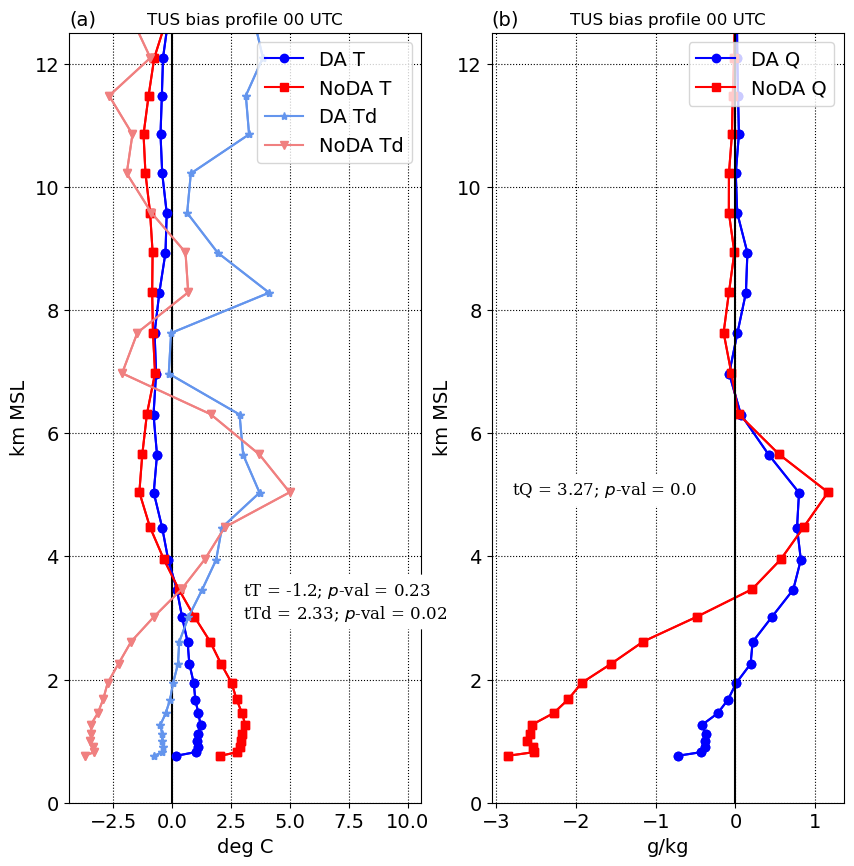

In [36]:
## PLOT ##
##########
fig,ax = plt.subplots(1, 2, figsize=(10, 10))
alph = ['(a)','(b)']
ax1 = ax.flatten()
c = 0
for axlist in ax1:
    ax1[0].plot(bTEMP_a,mZALT_a/1000,'b',marker='o')
    ax1[0].plot(bTEMP_n,mZALT_n/1000,'r',marker='s')
    ax1[0].plot(bTDEW_a,mZALT_a/1000,'cornflowerblue',marker='*')
    ax1[0].plot(bTDEW_n,mZALT_n/1000,'lightcoral',marker='v')
    ax1[1].plot(bMIXR_a,mZALT_a/1000,'b',marker='o')
    ax1[1].plot(bMIXR_n,mZALT_n/1000,'r',marker='s')
    ax1[0].legend(['DA T','NoDA T','DA Td','NoDA Td'],loc=1,fontsize=14)
    ax1[1].legend(['DA Q','NoDA Q'],loc=1,fontsize=14)
    ax1[c].set_title(SITE_obs + ' bias profile '+ti+' UTC')
    ax1[c].set_title(alph[c],loc='left',fontsize=14)
    ax1[c].set_ylim(0,12.5)
    ax1[c].axvline(0,color='k')
    ax1[0].set_xlabel('deg C',fontsize=14)
    ax1[1].set_xlabel('g/kg',fontsize=14)
    ax1[c].set_ylabel('km MSL',fontsize=14)
    ax1[c].grid(color='black', linestyle='dotted')
    ax1[c].tick_params(axis='x',labelsize=14)
    ax1[c].tick_params(axis='y',labelsize=14)

    ax1[0].annotate('tT = '+ttestTe+ '; $p$-val = '+pvalTe+'\n'+
                   'tTd = '+ttestTd+ '; $p$-val = '+pvalTd,(3.,3.),fontsize=12, fontname='serif',
            bbox=dict(boxstyle='square',fc='w',ec='w'))
    ax1[1].annotate('tQ = '+ttestMX+ '; $p$-val = '+pvalMX,(-2.8,5.),fontsize=12, fontname='serif',
            bbox=dict(boxstyle='square',fc='w',ec='w'))
    c = c + 1


## SAVE
dir_out = '/home/bayu/PLOTS/ARIZONA_PRO/RAOB/'
plotfile  = 'BIAS_RAOB-'+SITE_obs+'-'+ti+'Z_CLIMA.png'
sf = fig.savefig(dir_out+plotfile, dpi=300, bbox_inches='tight')

plt.show()
plt.close()